# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import load
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, csc_matrix
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML
from itertools import chain

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

# Notation

<table>
    <tr>
        <td>$i$</td>
        <td>Item</td>
    </tr>
    <tr>
        <td>$u$</td>
        <td>User</td>
    </tr>
    <tr>
        <td>$I_{u}$</td>
        <td>Rated items/interactions of user u</td>
    </tr>
    <tr>
        <td>$sim(i, j)$</td>
        <td>Similarity of items i and j</td>
    </tr>
    <tr>
        <td>$dist(i, j)$</td>
        <td>Distance between items i and j</td>
    </tr>
    <tr>
        <td>$novelty(i, u)$</td>
        <td>Novetly of item i for user u</td>
    </tr>
    <tr>
        <td>$unexpectedness(i, u)$</td>
        <td>Unexpectedness of item i for user u</td>
    </tr>
    <tr>
        <td>$relevance(i, u)$</td>
        <td>Relevance of item i for user u</td>
    </tr>
    <tr>
        <td>$serendipity(i, u)$</td>
        <td>Serendipity of item i for user u</td>
    </tr>
</table>

# Metrics

## Novelty

Metrics based on an items distance from user profile (items a user has consumed) [S. Vargas, P. Castells]

$$ distm(i, j) = 1 - sim(i, j) $$

Similarity metric must satisfy $sim(i, j) \in [0, 1]$, where 0 is unsimilar and 1 is totally similar.

$ novelty_1 $ returns the distance to the most dissimilar item (among all rated items)

$$ novelty_1(i, u) = 1 - \min_{j \in I_{u}} {dist(i, j)} $$

$ novelty_2 $ returns the mean of all distances

$$ novelty_2(i, u) = 1 - \frac {1}{|I_{u}|} \sum_{j \in I_{u}} dist(i, j) $$

$novelty_2$ returns values from range $[0, 1]$, where 0 means that user is already familiar with item $i$ and 1 means that item $i$ is new to the user.

In [4]:
def similarity(i, j):
    return cosine_similarity([i], [j])[0]

def distance(i, j):
    return 1 - similarity(i, j)

In [5]:
def novelty1(i, rated_items):
    """
    The first variation of novelty metric proposed by S. Vargas and P. Castells.
    
    Parameters
    ----------
    i
        Item to be computed novelty of
    rated_items : list
        Rated items by user, for who we compute the novelty of item i
    """
    return 1 - np.min([distance(i, j) for j in rated_items])

In [6]:
def novelty2(i, rated_items):
    """
    The second variation of novelty metric proposed by S. Vargas and P. Castells.
    
    Parameters
    ----------
    i
        Item to be computed novelty of
    rated_items : list
        Rated items by user, for who we compute the novelty of item i
    """
    return 1 - (1 / len(rated_items)) * np.sum([distance(i, j) for j in rated_items])

In [7]:
def novelty(recommendations, user_profile):
    result = []
    for recommendation in recommendations:
        result.append(novelty(recommendation, user_profile))
    return np.sum(result) / len(result)

## Unexpectedness

## Doesn't work!

<table>
    <tr>
        <td>$p(i)$</td>
        <td>Probability that any user has rated item i</td>
    </tr>
    <tr>
        <td>$p(i, j)$</td>
        <td>Probability that items i and j are rated together</td>
    </tr>
</table>

<i>Point-wise mutual information</i> indicates how similar two items are based on the numbers of users who have rated both items and each item separately: [Kaminskas, Bridge]

$$ PMI(i, j) = -\log_2 \frac {p(i, j)}{p(i)p(j)}/\log_2 p(i, j) = - \frac {\log_2 {p(i, j)} - \log_2 {p(i)p(j)}} {\log_2 p(i, j)} $$

$PMI(i, j) \in [-1, 1]$, where -1 indicates that items i and j are never rated together, while 1 indicates that items i and j are always rated together.

In [8]:
def single_probability(i):
    """
    Returns the probability that user has rated the film.
    
    Parameters
    ----------
    i : np.array
        Numpy 1-D array containing item ratings
    """
    return np.sum(i, axis=0) / len(i)

In [9]:
def together_rated_probability(i, j):
    """
    Returns the probability that both items are rated together.
    
    Parameters
    ----------
    i : np.array
        Numpy 1-D array containing item ratings of the first item
    j : np.array
        Numpy 1-D array containing item ratings of the second item
    """
    return np.sum([i + j == 2]) / len(i)

In [10]:
def pmi(i, j):
    """
    Point-wise mutual information.
    """
    p_i = single_probability(i)
    p_j = single_probability(j)
    p_i_j = together_rated_probability(i, j)
    return -np.log2(p_i_j / (p_i * p_j) + 1e-6) / np.log2(p_i_j + 1e-6)

Based on PMI, unexpectedness has two variations:

$$ unexpectedness_{1}(i, u) = \max_{j \in I_{u}} {PMI(i, j)} $$

$$ unexpectedness_{2}(i, u) = \frac {1}{|I_{u}|} \sum_{j \in I_{u}} {PMI(i, j)} $$

In [11]:
def unexpectedness1(i, rated_items):
    return np.max([pmi(i, j) for j in rated_items])

In [12]:
def unexpectedness2(i, rated_items):
    return 1 / len(rated_items) * np.sum([pmi(i, j) for j in rated_items])

## Works!

In [13]:
def unexpectedness(recommendations, primitive_recommendations):
    return len(recommendations[~np.isin(recommendations, primitive_recommendations)]) / len(recommendations)

## Relevance

We propose 2 variations based on the user profile:

$$ relevance_{1}(i, u) = \min_{j \in S \subset I_{u}} sim(i, j) $$

$$ relevance_{2}(i, u) = \frac {1}{|I_{u}|} \sum_{j \in S \subset I_{u}} sim(i, j) $$

Where *S* is a subset of rated items by user u, e.g. ***k*** most recent interactions.

In [14]:
def relevance1(i, rated_items_subset):
    return np.min([similarity(i, j) for j in rated_items_subset])

In [15]:
def relevance2(i, rated_items_subset):
    return 1 / len(rated_items_subset) * np.sum([similarity(i, j) for j in rated_items_subset])

In [16]:
def relevance(recommendations, user_profile):
    result = []
    for recommendation in recommendations:
        result.append(relevance2(recommendation, user_profile))
    return np.sum(result) / len(result)

## Serendipity

We suggest a serendipity metric, that takes into account item's novelty, unexpectedness and relevance. 

$$ serendipity(i, u) = \alpha \ novelty(i, u) + \beta \ unexpectedness(i, u) + \gamma \ relevance(i, u) $$

$ \alpha + \beta + \gamma = 1 $ equation must be satisfied, where coefficients can be found empirically or adjusted by the learning algorithm.

If any of three coefficients is set to 0, then the serendipity definition may vary. [A Survey of Serendipity in Recommender Systems, Kotkov, Wang & Veijalainen]

In [17]:
def serendipity(items, recommendations, primitive_recommendations, user_profile, alpha=0.3, beta=0.3, gamma=0.4):
    result = []
    for item in items:
        _novelty = alpha * novelty2(item, user_profile)
        _relevance = gamma * relevance2(item, user_profile)
        result.append(_novelty + _relevance)
    unexp = beta * unexpectedness(recommendations, primitive_recommendations)
    return np.sum((np.sum(result) + unexp) / len(result)) if len(result) > 0 else 0

# Evaluation

Movies dataset.

In [18]:
movies_df = pd.read_csv('jupyter/data/movies.csv')

In [19]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
movies_df[movies_df['title'].str.contains('Iron Man')]

,movieId,title,genres
12666,59315,Iron Man (2008),Action|Adventure|Sci-Fi
15271,77561,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX
21064,102007,"Invincible Iron Man, The (2007)",Animation
21075,102051,Iron Man: Rise Of Technovore (2013),Animation
21101,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX
32947,136455,Iron Man & Captain America: Heroes United (2014),Action|Adventure|Animation
35339,142056,Iron Man & Hulk: Heroes United (2013),Action|Adventure|Animation
37496,147070,Iron Man (1951),Drama
46217,167296,Iron Man (1931),Drama


In [21]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


Movies dataset with one-hot encoding.

In [22]:
movies_extended_df = load('C:\\Users\\Daniil\\Downloads\\t_film_profile_sem_0_and_com_001.pickle')

In [23]:
movies_extended_df.head()

node,30,65,74,75,83,90,100,107,108,110,...,70078755,70078760,70078761,70078764,70078766,70078779,70078781,70078784,70078788,70078789
movieId,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
movies_extended_df[11033]

movieId
2         0.0
3         0.0
5         0.0
6         0.0
11        0.0
         ... 
465044    0.0
467731    0.0
468343    0.0
468707    0.0
469172    0.0
Name: 11033, Length: 45267, dtype: float64

In [22]:
movies_extended_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45267 entries, 2 to 469172
Columns: 28675 entries, 30 to 70078789
dtypes: float64(28675)
memory usage: 9.7 GB


Rating dataset where users have 3-5 interactions.

In [2]:
ratings_cleaned_df = pd.read_csv('jupyter/test_datasets5/df_ratings_drop_users_3-5.csv')
ratings_cleaned_df = ratings_cleaned_df.sort_values(['userId', 'timestamp'])

In [24]:
ratings_cleaned_df.head(30)

,userId,movieId,rating,timestamp
14876,0,145,3.0,1216755656
14877,0,1729,3.5,1216755676
14878,0,1953,3.5,1216755747
14879,0,249,3.0,1216755814
14880,0,431,4.0,1216922547
57058,1,1183,3.0,877373332
57059,1,1416,4.0,877373333
57060,1,1617,3.0,877373333
57061,2,2858,5.0,940199496
57062,2,2890,2.0,940199572


In [25]:
ratings_cleaned_df[ratings_cleaned_df['userId'] == 1]

,userId,movieId,rating,timestamp
57058,1,1183,3.0,877373332
57059,1,1416,4.0,877373333
57060,1,1617,3.0,877373333


In [26]:
from abc import ABC, abstractmethod

class Model(ABC):
    def __init__(self, **kwargs):
        pass
    
    @abstractmethod
    def fit(self):
        pass

In [27]:
from sklearn.neighbors import NearestNeighbors

class KNN(Model):
    def __init__(self, **kwargs):
        self.model = NearestNeighbors(kwargs)
    
    def fit(self, data):
        self.model.fit(data)
    
    def neighbours(self, user, k):
        return self.model.kneighours(user, k)

In [28]:
ratings_cleaned_df.describe()

,userId,movieId,rating,timestamp
count,61448.000000,61448.000000,61448.000000,6.144800e+04
mean,7185.001465,10706.678736,3.670648,1.149198e+09
std,4148.661432,30357.378012,1.169258,2.260599e+08
min,0.000000,1.000000,0.500000,8.580799e+08
25%,3592.750000,920.000000,3.000000,9.571186e+08
50%,7193.000000,1856.000000,4.000000,9.944568e+08
75%,10784.000000,2926.000000,5.000000,1.390738e+09
max,14350.000000,191367.000000,5.000000,1.537882e+09


In [3]:
X_train = load('../../jupyter/testData/3-5/train_data.pickle')
X_test = load('../../jupyter/testData/3-5/test_data.pickle')

In [6]:
X_train.shape[1]

4809

In [4]:
X_train.shape, X_test.shape

((13489, 4809), (862, 4809))

In [16]:
13489/14351

0.9399344993380252

In [15]:
13489 + 862

14351

In [12]:
X_test_prepared = load('jupyter/testData/3-5/test_data_prepare_for_recom.pickle')

In [13]:
X_test_prepared.head()

,user_movies_profile_simple,user_movies_profile_dataframe,control_item,user_keep_movies
user,,,,
11400,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,148626,"[318, 858]"
4816,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,1031,"[255, 260, 3664]"
11080,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,2406,"[920, 1617]"
698,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,318,"[5952, 7153]"
4741,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,3013,"[537, 1054, 1270]"


In [14]:
X_test_prepared.shape

(862, 4)

In [33]:
items_ratings_df = load('jupyter/testData/3-5/item_sum_dif_rating.pickle')
items_ratings_df['movieId'] = items_ratings_df['novieId']
items_ratings_df.drop(['novieId'], axis=1, inplace=True)

In [34]:
ratings_cleaned_df

,userId,movieId,rating,timestamp
14876,0,145,3.0,1216755656
14877,0,1729,3.5,1216755676
14878,0,1953,3.5,1216755747
14879,0,249,3.0,1216755814
14880,0,431,4.0,1216922547
...,...,...,...,...
35633,14350,593,5.0,962798390
35634,14350,3249,3.0,962798390
35635,14350,920,3.0,962798509
35636,14350,1721,3.0,962798526


In [35]:
items_ratings_df

,index,sum_rating,movieId
0,0,-17.958333,1
1,1,-9.483333,2
2,2,4.566667,3
3,3,-4.550000,4
4,4,1.933333,5
...,...,...,...
4804,4804,0.000000,188679
4805,4805,-1.233333,189333
4806,4806,0.166667,189713
4807,4807,0.000000,191351


In [36]:
from application.model.userBased.userBasedKNNpopular import UserBasedKNNpopularity
from application.model.userBased.userBasedKNNFreq import UserBasedKNN
# from application.model.userBased.simpleUserBasedKNN import UserBasedKNN

In [37]:
from sklearn.neighbors import NearestNeighbors

In [38]:
X_test_items = []
for k, v in X_test.iterrows():
    f = v[v > 0.0]
    X_test_items = np.concatenate((X_test_items, np.array(f.index)), axis=0)

alfa = len(np.unique(X_test_items))
gamma = len(X_test.columns)
beta = gamma / alfa
print('beta:', beta)

beta: 1.713216957605985


In [39]:
params = {
    'K': 50
}

In [40]:
primitive_model_name = 'userBasedKNN'
primitive_model = UserBasedKNN(primitive_model_name, 'config/public/config.ini', X_train)
primitive_model.preprocess()
primitive_model.fit(params)

In [41]:
model_name = 'userBasedKNNpopularity'
model = UserBasedKNNpopularity(model_name, 'config/public/config.ini', X_train, 1, items_ratings_df)
model.preprocess()
model.fit(params)

In [42]:
# model = NearestNeighbors(n_neighbors=10)
# model.fit(csc_matrix(X_train))

In [43]:
X_test.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187593,187595,187613,187717,188301,188679,189333,189713,191351,191367
userId,,,,,,,,,,,,,,,,,,,,,
11033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X_test_prepared.head()

,user_movies_profile_simple,user_movies_profile_dataframe,control_item,user_keep_movies
user,,,,
11033,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,2879,"[356, 558, 1210, 1390]"
13789,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,736,"[141, 648]"
2252,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,260,"[2710, 2762, 2858]"
6282,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,2959,"[1193, 1210, 3425]"
12086,movieId 1 0.0 2 0.0 3 ...,movieId 1 2 3 4 5 ...,1242,"[1194, 1198]"


In [ ]:
X_test_prepared.shape

In [63]:
n = 10
hit = 0
recommendations = {}
primitive_recommendations = {}
unexp_recommendations = []
unexp_primitive_recommendations = []

for user_id, user_profile in tqdm(X_test_prepared.iterrows()): # iterate over test users, user_profile is a tuple
    prediction = model.predictItemByUser(user_profile[1], user_profile[0], n)
    primitive_prediction = primitive_model.predictItemByUser(None, user_profile[0], n, ratings_cleaned_df)
    if prediction is None or prediction.ndim == 0:
        continue
    if user_profile[2] in prediction: # if prediction contains control item increase hit counter
        hit += 1
    recommendations[user_id] = prediction
    primitive_recommendations[user_id] = primitive_prediction
    unexp_recommendations.append(prediction)
    unexp_primitive_recommendations.append(primitive_prediction)

(3588, 4)

In [45]:
n = 10
hit = 0
recommendations = {}
primitive_recommendations = {}
unexp_recommendations = []
unexp_primitive_recommendations = []

for user_id, user_profile in tqdm(X_test_prepared.iterrows()): # iterate over test users, user_profile is a tuple
    prediction = model.predictItemByUser(user_profile[1], user_profile[0], n)
    primitive_prediction = primitive_model.predictItemByUser(None, user_profile[0], n, ratings_cleaned_df)
    if prediction is None or prediction.ndim == 0:
        continue
    if user_profile[2] in prediction: # if prediction contains control item increase hit counter
        hit += 1
    recommendations[user_id] = prediction
    primitive_recommendations[user_id] = primitive_prediction
    unexp_recommendations.append(prediction)
    unexp_primitive_recommendations.append(primitive_prediction)

13it [00:02,  6.90it/s]C:\Users\Daniil\Desktop\recommender\application\model\userBased\userBasedKNNpopular.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  return row['upper_score'] / bottom_score
16it [00:02,  7.16it/s]C:\Users\Daniil\Desktop\recommender\application\model\userBased\userBasedKNNpopular.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  return row['upper_score'] / bottom_score
22it [00:03,  7.05it/s]C:\Users\Daniil\Desktop\recommender\application\model\userBased\userBasedKNNpopular.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  return row['upper_score'] / bottom_score
55it [00:07,  7.60it/s]C:\Users\Daniil\Desktop\recommender\application\model\userBased\userBasedKNNpopular.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  return row['upper_score'] / bottom_score
57it [00:08,  7.55it/s]C:\Users\Daniil\Desktop\recommender\application\model\userBased\userBasedKNNpopular.py:113: RuntimeWa

In [46]:
def flatten(array):
    result = []
    for row in array:
        result.extend(row)
    return result

In [47]:
recall = hit / len(X_test_prepared)
coverage = len(np.unique(flatten([j for i, j in recommendations.items()]))) / len(items_ratings_df['movieId'].unique())

In [48]:
print('Recall: {:0.3f}, coverage: {:0.3f}'.format(recall, coverage))

Recall: 0.102, coverage: 0.366


In [49]:
serendipity_results = []

for user_id in tqdm(X_test.index):
    recommended_items = movies_extended_df[movies_extended_df.index.isin(recommendations[user_id])].values
    user_profile = movies_extended_df[movies_extended_df.index.isin(X_test_prepared[X_test_prepared.index == user_id]['user_keep_movies'].values[0])].values
    if len(user_profile) == 0 or len(recommendations[user_id]) == 0:
        continue
    serendipity_results.append(serendipity(recommended_items, recommendations[user_id],
                                           primitive_recommendations[user_id], user_profile))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3588/3588 [01:00<00:00, 59.37it/s]


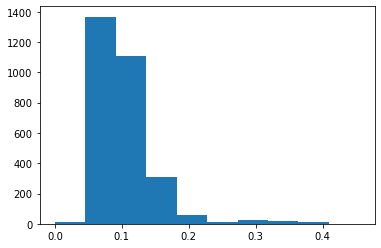

In [50]:
plt.hist(serendipity_results);

In [51]:
X_test

movieId,1,2,3,4,5,6,7,8,9,10,...,187593,187595,187613,187717,188301,188679,189333,189713,191351,191367
userId,,,,,,,,,,,,,,,,,,,,,
11033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
X_test[X_test[77561] > 0]

movieId,1,2,3,4,5,6,7,8,9,10,...,187593,187595,187613,187717,188301,188679,189333,189713,191351,191367
userId,,,,,,,,,,,,,,,,,,,,,
5241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
movies_df[movies_df['movieId'] == 189333]

,movieId,title,genres
56350,189333,Mission: Impossible - Fallout (2018),Action|Adventure|Thriller


In [54]:
def movies_by_id(ids):
    for i in ids:
        display(HTML(movies_df[movies_df['movieId'] == i].to_html()))

In [55]:
X_test[X_test.index == 3203].replace(0, np.NaN).dropna(axis=1)

movieId,1,2,3,4,5,6,7,8,9,10,...,187593,187595,187613,187717,188301,188679,189333,189713,191351,191367
userId,,,,,,,,,,,,,,,,,,,,,


In [56]:
my_user = X_test[X_test.index == 11400].copy()

In [57]:
my_user[my_user > 0] = 0

In [58]:
my_user[77561] = 5.0
my_user[122892] = 4.5
# my_user[122912] = 5.0

In [59]:
iron_man_2 = movies_df[movies_df['movieId'] == 77561].copy().values
avengers = movies_df[movies_df['movieId'] == 122892].copy().values
avengers_2 = movies_df[movies_df['movieId'] == 122912].copy().values

In [60]:
novelty2(avengers_2, [iron_man_2, avengers])

ValueError: could not convert string to float: 'Avengers: Infinity War - Part I (2018)'

In [ ]:
novelty2(X_train[4], [iron_man_2, avengers])

In [ ]:
unexpectedness2(avengers, [avengers_2])

In [ ]:
unexpectedness2(X_train[4], [iron_man_2, avengers])

In [ ]:
relevance2(avengers_2, [iron_man_2, avengers])

In [ ]:
movies_by_id([1])

In [ ]:
relevance2([1, 0, 1], [[1, 1, 0], [1, 0, 0]])

In [ ]:
similarity([1, 0, 1], [1, 1, 1])